In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/DataCollection/tensorflow-ml-nlp-tf2/4.TEXT_CLASSIFICATION')

In [3]:
os.getcwd()

'/content/drive/MyDrive/DataCollection/tensorflow-ml-nlp-tf2/4.TEXT_CLASSIFICATION'

## 모듈 불러오기

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

## 시각화 함수

In [27]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '') ## 2번째 arg에 ''가 왜 필요한지는 확인이 필요하다.
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## 학습 데이터 경로 정의 

In [6]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'  # 데이터에 대한 사전(vocab) 정보

## 랜덤 시드 고정

In [7]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

## 파일 로드

In [8]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [17]:
train_input.shape

(25000, 174)

In [18]:
train_input[0]

array([  411,   793,  3342,    17,   441,   600,  1500,    15,  4424,
        1851,   998,   146,   342,  1442,   743,  2424,     4,  8815,
         418,    70,   637,    69,   237,    94,   541,  8815, 26055,
       26056,   120,     1,  8815,   323,     8,    47,    20,   323,
         167,    10,   207,   633,   635,     2,   116,   291,   382,
         121, 15535,  3315,  1501,   574,   734, 10013,   923, 11578,
         822,  1239,  1408,   360,  8815,   221,    15,   576,  8815,
       22224,  2274, 13426,   734, 10013,    27, 28606,   340,    16,
          41, 18687,  1500,   388, 11243,   165,  3962,  8815,   115,
         627,   499,    79,     4,  8815,  1430,   380,  2163,   114,
        1919,  2503,   574,    17,    60,   100,  4875,  5100,   260,
        1268, 26057,    15,   574,   493,   744,   637,   631,     3,
         394,   164,   446,   114,   615,  3266,  1160,   684,    48,
        1175,   224,     1,    16,     4,  8815,     3,   507,    62,
          25,    16,

In [12]:
prepro_configs

{'vocab': {'movie': 1,
  'film': 2,
  'one': 3,
  'like': 4,
  'good': 5,
  'time': 6,
  'even': 7,
  'would': 8,
  'story': 9,
  'really': 10,
  'see': 11,
  'well': 12,
  'much': 13,
  'get': 14,
  'bad': 15,
  'people': 16,
  'also': 17,
  'first': 18,
  'great': 19,
  'made': 20,
  'way': 21,
  'make': 22,
  'could': 23,
  'movies': 24,
  'think': 25,
  'characters': 26,
  'character': 27,
  'watch': 28,
  'two': 29,
  'films': 30,
  'seen': 31,
  'many': 32,
  'life': 33,
  'plot': 34,
  'acting': 35,
  'never': 36,
  'love': 37,
  'little': 38,
  'best': 39,
  'show': 40,
  'know': 41,
  'ever': 42,
  'man': 43,
  'better': 44,
  'end': 45,
  'still': 46,
  'say': 47,
  'scene': 48,
  'scenes': 49,
  'go': 50,
  'something': 51,
  'back': 52,
  'real': 53,
  'watching': 54,
  'though': 55,
  'thing': 56,
  'old': 57,
  'years': 58,
  'actors': 59,
  'director': 60,
  'work': 61,
  'another': 62,
  'new': 63,
  'nothing': 64,
  'funny': 65,
  'actually': 66,
  'makes': 67,
  'look

## 모델 하이퍼파라메터 정의

In [13]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],  ## 사전정의된 vocab size
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

## 모델 선언 및 컴파일

In [19]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):                                        # 매개변수로 모델 레이어의 입력 및 출력 차원 수를 정의하는 하이퍼파라미터 정보를 dict 객체로 받는다.
        super(RNNClassifier, self).__init__(name=kargs['model_name'])   #super().__init__: 부모클래스의 __init__ 함수를 호출하는 것!  
        # 이 __init__함수 인자에 모델 이름을 전달하면 tf.keras.Model을 상속받은 모든 자식은 해당 모델의 이름으로 공통적으로 사용하게 된다.
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],  # lookup table https://wikidocs.net/33793 
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)  #출력 시퀀스를 모두 출력. LSTM 층을 여러개 쌓을 때는 반드시 필요(https://tykimos.github.io/2017/04/09/RNN_Getting_Started/)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])  #마지막 스텝의 은닉 상태 벡터만 출력
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [20]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

## Callback 선언

In [21]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/rnn_classifier_en -- Folder create complete 



## 모델 학습

In [22]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5053
Epoch 00001: val_accuracy improved from -inf to 0.50960, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 286s 2s/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5096
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5345
Epoch 00002: val_accuracy improved from 0.50960 to 0.75760, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 291s 2s/step - loss: 0.6805 - accuracy: 0.5345 - val_loss: 0.4860 - val_accuracy: 0.7576
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8566
Epoch 00003: val_accuracy improved from 0.75760 to 0.88440, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 293s 2s/step - loss: 0.3408 - accuracy: 0.8566 - val_loss: 0.27

## 결과 플롯

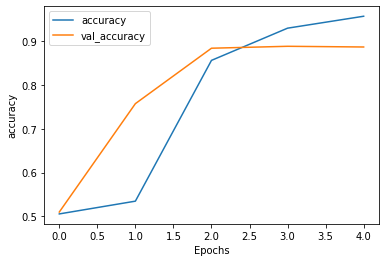

In [23]:
plot_graphs(history, 'accuracy')

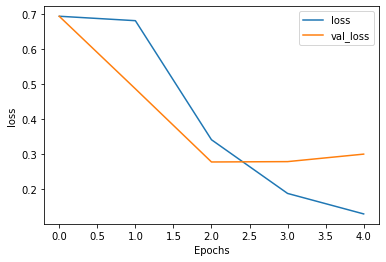

In [24]:
plot_graphs(history, 'loss')

## 테스트 데이터 불러오기

In [ ]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'


test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

## 베스트 모델 불러오기

In [ ]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

## 테스트 데이터 예측하기

In [ ]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [ ]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3)